# SECTION A — Data Analysis & Insights (Python)





1. Data Quality Check & Cleaning

In [ ]:
import pandas as pd

# Example DataFrame (replace this with your actual data)
# Load datasets
employee_data = pd.read_csv('employee_data.csv')
compensation_data = pd.read_csv('Industry Compensation.csv')
ratings_data = pd.read_csv('Employee Rating.csv')

# STEP 1: Remove commas from 'Compensation' and convert to numeric
employee_data['Compensation'] = (
    employee_data['Compensation']
    .astype(str)                             # Ensure it's string
    .str.replace(',', '', regex=False)       # Remove commas
    .str.strip()                             # Remove any leading/trailing spaces
)

# Convert to numeric, setting errors='coerce' to handle any non-numeric strings
employee_data['Compensation'] = pd.to_numeric(employee_data['Compensation'], errors='coerce')

# STEP 2: Fill missing 'Compensation' with median by 'Role'
employee_data['Compensation'] = (
    employee_data.groupby('Role')['Compensation']
    .transform(lambda x: x.fillna(x.median()))
)

# STEP 3: Handle 'Years of Experience' (convert and fill missing)
employee_data['Years of Experience'] = pd.to_numeric(employee_data['Years of Experience'], errors='coerce')
employee_data['Years of Experience'] = employee_data['Years of Experience'].fillna(employee_data['Years of Experience'].median())

# STEP 4: Check for missing values
print("Missing values in cleaned data:")
print(employee_data.isnull().sum())


Missing values in cleaned data:
Employee_ID              0
Name                     0
Role                     0
Location                 0
Years of Experience    300
Active?                  0
Compensation             0
Last Working Day       263
dtype: int64


2. Turnover Analysis: Identify location & role with highest turnover

In [ ]:

# Read CSV with proper handling of thousands separator
df = pd.read_csv('employee_data.csv', thousands=',')

# Clean 'Years of Experience'
df['Years of Experience'] = df['Years of Experience'].replace({
    '0-1': 0.5, '01-Feb': 1.1, '02-Mar': 2.2, '03-Apr': 3.3,
    '04-May': 4.4, '05-Jun': 5.5, '06-Jul': 6.6, '08-Sep': 8.9
})
df['Years of Experience'] = pd.to_numeric(df['Years of Experience'], errors='coerce')

# Convert 'Compensation' to integer
df['Compensation'] = pd.to_numeric(df['Compensation'], errors='coerce')

# Convert 'Active?' to boolean
df['Active?'] = df['Active?'].map({'Y': True, 'N': False})

# Parse 'Last Working Day' as datetime
df['Last Working Day'] = pd.to_datetime(df['Last Working Day'], errors='coerce', dayfirst=True)

# Optional: Display summary
print(df.info())
print(df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee_ID          300 non-null    int64         
 1   Name                 300 non-null    object        
 2   Role                 300 non-null    object        
 3   Location             300 non-null    object        
 4   Years of Experience  289 non-null    float64       
 5   Active?              300 non-null    bool          
 6   Compensation         300 non-null    int64         
 7   Last Working Day     33 non-null     datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 16.8+ KB
None
   Employee_ID            Name            Role  Location  Years of Experience  \
0            1    Aditi Khanna         Analyst    Jaipur                  1.1   
1            2      Pooja Kaur  Senior Analyst  Banglore            

3. Compensation Competitiveness

In [ ]:
import pandas as pd

# Assuming employee_data is already loaded and processed as you did
employee_data['Years of Experience'] = pd.to_numeric(employee_data['Years of Experience'], errors='coerce')
employee_data = employee_data.dropna(subset=['Years of Experience'])

bins = [0, 1, 2, 5, 10, 20, float('inf')]
labels = ['0-1', '1-2', '2-5', '5-10', '10-20', '20+']
employee_data['ExperienceRange'] = pd.cut(employee_data['Years of Experience'], bins=bins, labels=labels, right=False)

# compensation_data is loaded (make sure you load it before this)
# Rename the compensation column to a consistent name
compensation_data = compensation_data.rename(columns={'Average Industry Compensation': 'Compensation_Industry'})

# You need to create 'ExperienceRange' in compensation_data as well.
# But since compensation_data likely doesn't have 'Years of Experience',
# you should have something to define 'ExperienceRange' there.
# Assuming 'ExperienceRange' already exists or you have a column from which you can create it.
# If it doesn't exist, you'll need to create it or adjust merge logic.

# If you don't have Years of Experience in compensation_data but have 'ExperienceRange' as a column:
if 'ExperienceRange' not in compensation_data.columns:
    print("Compensation data missing 'ExperienceRange' column, attempting to create it from 'Years of Experience' if available.")
    if 'Years of Experience' in compensation_data.columns:
        compensation_data['Years of Experience'] = pd.to_numeric(compensation_data['Years of Experience'], errors='coerce')
        compensation_data = compensation_data.dropna(subset=['Years of Experience'])
        compensation_data['ExperienceRange'] = pd.cut(compensation_data['Years of Experience'], bins=bins, labels=labels, right=False)
    else:
        # If no 'Years of Experience' or 'ExperienceRange' in compensation_data,
        # you cannot merge on 'ExperienceRange'.
        # Consider merging only on 'Role' or adjust accordingly.
        print("No 'Years of Experience' or 'ExperienceRange' in compensation_data; merging only on 'Role'.")
        merged = pd.merge(employee_data, compensation_data, on='Role', how='left')
else:
    # If 'ExperienceRange' exists in compensation_data, merge on both columns
    merged = pd.merge(employee_data, compensation_data, on=['Role', 'ExperienceRange'], how='left')

# Rename employee compensation column for clarity if needed
merged = merged.rename(columns={'Compensation': 'Compensation_Emp'})

# Calculate Compensation Gap if both columns exist
if 'Compensation_Industry' in merged.columns and 'Compensation_Emp' in merged.columns:
    merged['CompensationGap'] = merged['Compensation_Industry'] - merged['Compensation_Emp']
    print(merged.groupby('Role')[['Compensation_Emp', 'Compensation_Industry', 'CompensationGap']].mean())
else:
    print("Cannot calculate CompensationGap because one or both compensation columns are missing.")


Compensation data missing 'ExperienceRange' column, attempting to create it from 'Years of Experience' if available.
No 'Years of Experience' or 'ExperienceRange' in compensation_data; merging only on 'Role'.
Empty DataFrame
Columns: [Compensation_Emp, Compensation_Industry, CompensationGap]
Index: []


4. Identify Reasons for Headcount Decline

In [ ]:
# Check actual column names first
print("Columns in employee_data:", employee_data.columns)

# Confirm required columns exist
required_cols = ['Compensation', 'Years of Experience', 'Rating', 'Status']
missing_cols = [col for col in required_cols if col not in employee_data.columns]
if missing_cols:
    print(f"Missing columns in employee_data: {missing_cols}")
else:
    # Create 'LeftCompany' column based on 'Status' == 'Inactive'
    employee_data['LeftCompany'] = (employee_data['Status'].str.lower() == 'inactive').astype(int)

    # Use correct column names, note I replaced 'Experience' with 'Years of Experience' if that matches your data
    corr_cols = ['Compensation', 'Years of Experience', 'Rating', 'LeftCompany']

    # Drop rows with NaN in these columns to avoid errors in corr()
    corr_data = employee_data[corr_cols].dropna()

    # Calculate correlation matrix
    corr = corr_data.corr()

    # Print correlation of all features with 'LeftCompany' sorted descending
    print(corr['LeftCompany'].sort_values(ascending=False))

    # Group by Status and print average Rating, drop NaN ratings for accuracy
    print(employee_data.groupby('Status')['Rating'].mean())


Columns in employee_data: Index(['Employee_ID', 'Name', 'Role', 'Location', 'Years of Experience',
       'Active?', 'Compensation', 'Last Working Day', 'ExperienceRange'],
      dtype='object')
Missing columns in employee_data: ['Rating', 'Status']


5. Recommendations (Summary in code comments)

In [ ]:
# 1. Close compensation gaps for roles with high turnover
# 2. Improve retention of employees with low ratings and high experience by upskilling/engagement programs
# 3. Focus on high turnover locations/roles for management attention
# 4. Consider performance-linked bonuses or stock options for senior staff


# SECTION B — Leadership Dilemmas: Compensation Changes Impact (Python)

Quantify financial impact of bonuses or stock units

In [ ]:
# Sample salary structure dataframe: columns = ['Role', 'Compensation', 'Count']
salaries = employee_data.groupby('Role')['Compensation'].agg(['mean', 'count']).reset_index()
salaries.columns = ['Role', 'AvgCompensation', 'Count']

# Define bonus or stock % for Senior Associate and Manager
bonus_pct = 0.10  # 10% bonus
stock_pct = 0.15  # 15% stock units

# Filter senior roles
senior_roles = ['Senior Associate', 'Manager']
senior_data = salaries[salaries['Role'].isin(senior_roles)].copy()

# Calculate bonus cost
senior_data['BonusCost'] = senior_data['AvgCompensation'] * bonus_pct * senior_data['Count']

# Calculate stock cost (assuming stock units valued similarly)
senior_data['StockCost'] = senior_data['AvgCompensation'] * stock_pct * senior_data['Count']

print(senior_data[['Role', 'BonusCost', 'StockCost']])

# Total impact on PnL
total_bonus = senior_data['BonusCost'].sum()
total_stock = senior_data['StockCost'].sum()

print(f"Total Bonus Cost: INR {total_bonus:,.0f}")
print(f"Total Stock Units Cost: INR {total_stock:,.0f}")


Empty DataFrame
Columns: [Role, BonusCost, StockCost]
Index: []
Total Bonus Cost: INR 0
Total Stock Units Cost: INR 0


# SECTION C — TECHNICAL ASSIGNMENT

Database SQL Scripts (for SQL Server)

Table creation (Employee, Compensation, Ratings)

In [ ]:
import sqlite3

# Connect to SQLite in-memory database (or a file database)
conn = sqlite3.connect(':memory:')  # or 'your_database.db'
cursor = conn.cursor()

# Create tables with SQL commands
cursor.execute('''
CREATE TABLE Employee (
    EmployeeID INTEGER PRIMARY KEY,
    EmployeeName TEXT,
    Role TEXT,
    Location TEXT,
    Experience REAL,
    Compensation REAL,
    Status TEXT -- 'Active' or 'Inactive'
);
''')

cursor.execute('''
CREATE TABLE IndustryCompensation (
    Role TEXT,
    ExperienceRange TEXT,
    AvgCompensation REAL,
    PRIMARY KEY (Role, ExperienceRange)
);
''')

cursor.execute('''
CREATE TABLE EmployeeRating (
    EmployeeID INTEGER,
    Rating REAL,
    ReviewCycle TEXT,
    PRIMARY KEY (EmployeeID, ReviewCycle),
    FOREIGN KEY (EmployeeID) REFERENCES Employee(EmployeeID)
);
''')

conn.commit()
print("Tables created successfully.")

# Don't forget to close connection when done
conn.close()


Tables created successfully.


# Stored Procedures

1. FilterEmployees by Role, Location, Status

In [ ]:
# Add Microsoft repo and key
!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/20.04/prod.list > /etc/apt/sources.list.d/mssql-release.list

# Update package info
!apt-get update

# Install Microsoft ODBC Driver 17 for SQL Server (accept EULA automatically)
!ACCEPT_EULA=Y apt-get install -y msodbcsql17

# Install unixODBC development headers (needed by pyodbc)
!apt-get install -y unixodbc-dev

# Install pyodbc Python package
!pip install pyodbc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100   983  100   983    0     0   3104      0 --:--:-- --:--:-- --:--:--  3110
OK
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    89  100    89    0     0    416      0 --:--:-- --:--:-- --:--:--   415
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 htt

In [ ]:
import pyodbc
print("Installed ODBC drivers:", pyodbc.drivers())


Installed ODBC drivers: []


In [ ]:
driver_name = 'ODBC Driver 17 for SQL Server'


In [ ]:
#Install ODBC driver and pyodbc in Colab (run this cell first)
!curl https://packages.microsoft.com/keys/microsoft.asc | sudo apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/20.04/prod.list | sudo tee /etc/apt/sources.list.d/mssql-release.list
!sudo apt-get update
!ACCEPT_EULA=Y sudo apt-get install -y msodbcsql17
!sudo apt-get install -y unixodbc-dev
!pip install pyodbc

# Now restart the runtime (Runtime -> Restart runtime) and then run the following code:

import pyodbc

# Check installed drivers after restart
print("Available ODBC drivers:", pyodbc.drivers())

driver_name = 'ODBC Driver 17 for SQL Server'  # Confirm this from the output above

server = 'your_server.database.windows.net'
database = 'your_database'
username = 'your_username'
password = 'your_password'

conn_str = (
    f'DRIVER={{{driver_name}}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

sql_create_proc = """
IF OBJECT_ID('dbo.FilterEmployees', 'P') IS NOT NULL
    DROP PROCEDURE dbo.FilterEmployees;

CREATE PROCEDURE dbo.FilterEmployees
    @Role NVARCHAR(50) = NULL,
    @Location NVARCHAR(50) = NULL,
    @IncludeInactive BIT = 0
AS
BEGIN
    SET NOCOUNT ON;

    SELECT
        EmployeeID,
        EmployeeName,
        Role,
        Location,
        Compensation,
        Status
    FROM Employee
    WHERE (@Role IS NULL OR Role = @Role)
      AND (@Location IS NULL OR Location = @Location)
      AND (Status = 'Active' OR @IncludeInactive = 1);
END
"""

try:
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()
    cursor.execute(sql_create_proc)
    conn.commit()
    print("Stored procedure created successfully.")
    cursor.close()
    conn.close()
except Exception as e:
    print("Error:", e)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100   983  100   983    0     0   4207      0 --:--:-- --:--:-- --:--:--  4218
OK
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    89  100    89    0     0    543      0 --:--:-- --:--:-- --:--:--   546
deb [arch=amd64,armhf,arm64] https://packages.microsoft.com/ubuntu/20.04/prod focal main
Hit:1 https://packages.microsoft.com/ubuntu/20.04/prod focal InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https:

2. Calculate Average Compensation by Location

In [ ]:
!curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
!curl https://packages.microsoft.com/config/ubuntu/20.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
!apt-get update
!ACCEPT_EULA=Y apt-get install -y msodbcsql17
!apt-get install -y unixodbc-dev
import pyodbc

# Fill these with your actual SQL Server connection info
server = 'your_server.database.windows.net'
database = 'your_database'
username = 'your_username'
password = 'your_password'

driver = 'ODBC Driver 17 for SQL Server'  # Make sure this driver is installed on your machine/environment

conn_str = (
    f'DRIVER={{{driver}}};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)

# SQL to drop the procedure if it exists, then create it
sql_create_proc = """
IF OBJECT_ID('dbo.CalculateAverageCompensation', 'P') IS NOT NULL
    DROP PROCEDURE dbo.CalculateAverageCompensation;

CREATE PROCEDURE dbo.CalculateAverageCompensation
    @Location NVARCHAR(50) = NULL
AS
BEGIN
    SET NOCOUNT ON;

    SELECT
        Location,
        AVG(Compensation) AS AvgCompensation
    FROM Employee
    WHERE (@Location IS NULL OR Location = @Location)
      AND Status = 'Active'
    GROUP BY Location;
END;
"""

try:
    # Connect to SQL Server
    conn = pyodbc.connect(conn_str)
    cursor = conn.cursor()

    # Execute the SQL command to create the procedure
    cursor.execute(sql_create_proc)
    conn.commit()

    print("Stored procedure 'CalculateAverageCompensation' created successfully.")

except Exception as e:
    print("Error:", e)

finally:
    # Close connections cleanly
    try:
        cursor.close()
    except:
        pass
    try:
        conn.close()
    except:
        pass


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100   983  100   983    0     0   4824      0 --:--:-- --:--:-- --:--:--  4842
OK
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    89  100    89    0     0    357      0 --:--:-- --:--:-- --:--:--   358
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://packages.microsoft.com/ubuntu/20.04/prod focal InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-securi

# Sample Python Backend Code for Step 2 (After loading data)

In [ ]:
!pip install ipython-sql
%load_ext sql
%sql sqlite://


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [ ]:
%%sql

DROP TABLE IF EXISTS Employees;

CREATE TABLE Employees (
    EmployeeID INTEGER PRIMARY KEY AUTOINCREMENT,
    EmployeeName TEXT,
    Role TEXT,
    Location TEXT,
    Compensation REAL,
    Experience REAL,
    Status TEXT
);

INSERT INTO Employees (EmployeeName, Role, Location, Compensation, Experience, Status) VALUES
('Alice Smith', 'Consultant', 'Bangalore', 90000, 3.5, 'Active'),
('Bob Jones', 'Analyst', 'Mumbai', 75000, 2, 'Active'),
('Carol Lee', 'Manager', 'Delhi', 120000, 7, 'Inactive'),
('David Kim', 'Consultant', 'Bangalore', 95000, 4, 'Active'),
('Eva Zhang', 'Analyst', 'Mumbai', 72000, 1, 'Active');


 * sqlite://
Done.
Done.
5 rows affected.


[]

In [ ]:
import sqlite3

conn = sqlite3.connect(':memory:')  # In-memory DB
cur = conn.cursor()

cur.execute('DROP TABLE IF EXISTS Employees;')

cur.execute('''
CREATE TABLE Employees (
    EmployeeID INTEGER PRIMARY KEY AUTOINCREMENT,
    EmployeeName TEXT,
    Role TEXT,
    Location TEXT,
    Compensation REAL,
    Experience REAL,
    Status TEXT
)
''')

employees = [
    ('Alice Smith', 'Consultant', 'Bangalore', 90000, 3.5, 'Active'),
    ('Bob Jones', 'Analyst', 'Mumbai', 75000, 2, 'Active'),
    ('Carol Lee', 'Manager', 'Delhi', 120000, 7, 'Inactive'),
    ('David Kim', 'Consultant', 'Bangalore', 95000, 4, 'Active'),
    ('Eva Zhang', 'Analyst', 'Mumbai', 72000, 1, 'Active')
]

cur.executemany('INSERT INTO Employees (EmployeeName, Role, Location, Compensation, Experience, Status) VALUES (?, ?, ?, ?, ?, ?)', employees)

conn.commit()

# Query example:
cur.execute("SELECT * FROM Employees")
rows = cur.fetchall()
for row in rows:
    print(row)

conn.close()


(1, 'Alice Smith', 'Consultant', 'Bangalore', 90000.0, 3.5, 'Active')
(2, 'Bob Jones', 'Analyst', 'Mumbai', 75000.0, 2.0, 'Active')
(3, 'Carol Lee', 'Manager', 'Delhi', 120000.0, 7.0, 'Inactive')
(4, 'David Kim', 'Consultant', 'Bangalore', 95000.0, 4.0, 'Active')
(5, 'Eva Zhang', 'Analyst', 'Mumbai', 72000.0, 1.0, 'Active')


In [ ]:
import sqlite3
import pandas as pd

def create_database():
    conn = sqlite3.connect(':memory:')
    cur = conn.cursor()

    # Drop table if exists
    cur.execute('DROP TABLE IF EXISTS Employees;')

    # Create table
    cur.execute('''
    CREATE TABLE Employees (
        EmployeeID INTEGER PRIMARY KEY AUTOINCREMENT,
        EmployeeName TEXT,
        Role TEXT,
        Location TEXT,
        Compensation REAL,
        Experience REAL,
        Status TEXT
    )
    ''')

    # Insert sample data - extend as needed
    employees = [
        ('Alice Smith', 'Consultant', 'Bangalore', 90000, 3.5, 'Active'),
        ('Bob Jones', 'Analyst', 'Mumbai', 75000, 2, 'Active'),
        ('Carol Lee', 'Manager', 'Delhi', 120000, 7, 'Inactive'),
        ('David Kim', 'Consultant', 'Bangalore', 95000, 4, 'Active'),
        ('Eva Zhang', 'Analyst', 'Mumbai', 72000, 1, 'Active'),
        ('Frank Liu', 'Senior Associate', 'Delhi', 110000, 6, 'Inactive'),
        ('Grace Park', 'Manager', 'Mumbai', 125000, 8, 'Active'),
        ('Hannah Scott', 'Consultant', 'Bangalore', 91000, 3, 'Inactive'),
        ('Ian Wright', 'Senior Associate', 'Mumbai', 108000, 5, 'Active'),
        ('Judy Chan', 'Analyst', 'Delhi', 68000, 2, 'Inactive'),
    ]

    cur.executemany('''
        INSERT INTO Employees (EmployeeName, Role, Location, Compensation, Experience, Status)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', employees)

    conn.commit()
    return conn, cur

def data_quality_check(cur):
    print("=== Data Quality Checks ===")
    # Check for null or missing values in any column
    cur.execute("""
        SELECT COUNT(*) FROM Employees
        WHERE EmployeeName IS NULL OR Role IS NULL OR Location IS NULL
        OR Compensation IS NULL OR Experience IS NULL OR Status IS NULL
    """)
    missing_count = cur.fetchone()[0]
    if missing_count > 0:
        print(f"Data Quality Issue: {missing_count} records have missing values.")
    else:
        print("No missing values detected.")

def turnover_by_location_and_role(cur):
    print("\n=== Turnover Analysis by Location and Role ===")
    # Turnover = count of inactive employees / total employees in that group
    query = '''
    SELECT Location, Role,
           COUNT(*) AS TotalEmployees,
           SUM(CASE WHEN Status = 'Inactive' THEN 1 ELSE 0 END) AS TurnoverCount,
           ROUND(100.0 * SUM(CASE WHEN Status = 'Inactive' THEN 1 ELSE 0 END) / COUNT(*), 2) AS TurnoverPercent
    FROM Employees
    GROUP BY Location, Role
    ORDER BY TurnoverPercent DESC
    '''
    cur.execute(query)
    rows = cur.fetchall()
    df = pd.DataFrame(rows, columns=['Location', 'Role', 'TotalEmployees', 'TurnoverCount', 'TurnoverPercent'])
    print(df)
    return df

def compensation_vs_industry(cur, industry_comp):
    print("\n=== Compensation vs Industry Standards ===")
    query = '''
    SELECT Role,
           ROUND(AVG(Compensation), 2) AS AvgCompensation,
           ROUND(AVG(Experience), 2) AS AvgExperience
    FROM Employees
    GROUP BY Role
    '''
    cur.execute(query)
    rows = cur.fetchall()
    df_emp = pd.DataFrame(rows, columns=['Role', 'AvgCompensation', 'AvgExperience'])
    df = pd.merge(df_emp, industry_comp, on='Role', how='left')
    df['Compensation vs Industry (%)'] = round((df['AvgCompensation'] / df['IndustryCompensation']) * 100, 2)
    print(df)
    return df

def analyze_headcount_decline():
    print("\n=== Main Reasons for Headcount Decline ===")
    print("""
- Higher turnover rates in certain locations and roles.
- Compensation for some roles might be below industry standards.
- Senior roles lack additional incentives such as bonuses or stock units.
- Possible lack of growth opportunities and employee engagement.
- Presence of inactive employees reducing active headcount.
""")

def recommend_retention_strategies():
    print("\n=== Recommendations to Retain Employees ===")
    print("""
1. Align compensation with or exceed industry benchmarks.
2. Introduce bonuses or stock units for senior roles (Senior Associate, Manager).
3. Enhance career development and training programs.
4. Improve employee engagement, work-life balance, and recognition.
5. Regular feedback and performance review processes.
""")

def financial_impact_analysis(cur):
    print("\n=== Financial Impact Analysis: Bonuses vs Stock Units ===")
    query = '''
    SELECT Role, Compensation
    FROM Employees
    WHERE Role IN ('Senior Associate', 'Manager')
    '''
    cur.execute(query)
    rows = cur.fetchall()
    df = pd.DataFrame(rows, columns=['Role', 'Compensation'])

    if df.empty:
        print("No Senior Associate or Manager data available for financial impact analysis.")
        return

    total_comp = df['Compensation'].sum()
    bonus_rate = 0.10  # 10% bonus assumed
    stock_units_rate = 0.15  # 15% stock units assumed value

    bonus_cost = total_comp * bonus_rate
    stock_units_cost = total_comp * stock_units_rate

    print(f"Total current compensation of senior roles: INR {total_comp:,.2f}")
    print(f"Estimated additional cost with 10% Bonuses: INR {bonus_cost:,.2f}")
    print(f"Estimated additional cost with 15% Stock Units: INR {stock_units_cost:,.2f}")

    recommendation = "Bonus" if bonus_cost < stock_units_cost else "Stock Units"
    print(f"Recommendation: Implement {recommendation} based on financial impact.")

def stakeholder_impact_and_implementation():
    print("\n=== Stakeholders and Implementation Recommendations ===")
    print("""
Stakeholders:
- Senior Associates and Managers (direct impact)
- HR and Compensation teams
- Finance department
- Executive leadership
- All employees (indirect impact)

Implementation Steps:
1. Communicate changes transparently to employees.
2. Obtain budget approval from finance.
3. Phase-wise rollout and monitor impact.
4. Train HR and managers on new compensation structures.
5. Collect feedback and adjust accordingly.
""")

def export_to_excel(conn):
    print("\nExporting employee data to 'techsolve_employee_data.xlsx' ...")
    df = pd.read_sql_query("SELECT * FROM Employees", conn)
    df.to_excel("techsolve_employee_data.xlsx", index=False)
    print("Export completed.")

def main():
    industry_comp = pd.DataFrame({
        'Role': ['Analyst', 'Consultant', 'Manager', 'Senior Associate'],
        'IndustryCompensation': [70000, 92000, 125000, 110000]
    })

    conn, cur = create_database()
    data_quality_check(cur)
    turnover_by_location_and_role(cur)
    compensation_vs_industry(cur, industry_comp)
    analyze_headcount_decline()
    recommend_retention_strategies()
    financial_impact_analysis(cur)
    stakeholder_impact_and_implementation()
    export_to_excel(conn)
    conn.close()

if __name__ == "__main__":
    main()


=== Data Quality Checks ===
No missing values detected.

=== Turnover Analysis by Location and Role ===
    Location              Role  TotalEmployees  TurnoverCount  TurnoverPercent
0      Delhi           Analyst               1              1           100.00
1      Delhi           Manager               1              1           100.00
2      Delhi  Senior Associate               1              1           100.00
3  Bangalore        Consultant               3              1            33.33
4     Mumbai           Analyst               2              0             0.00
5     Mumbai           Manager               1              0             0.00
6     Mumbai  Senior Associate               1              0             0.00

=== Compensation vs Industry Standards ===
               Role  AvgCompensation  AvgExperience  IndustryCompensation  \
0           Analyst         71666.67           1.67                 70000   
1        Consultant         92000.00           3.50               

# SQL Server Table Schema + Stored Procedures

In [ ]:
import sqlite3

# Create in-memory SQLite DB
conn = sqlite3.connect(':memory:')
cur = conn.cursor()

# Create table
cur.execute('''
CREATE TABLE Employees (
    EmployeeID INTEGER PRIMARY KEY AUTOINCREMENT,
    EmployeeName TEXT,
    Role TEXT,
    Location TEXT,
    Compensation REAL,
    Experience REAL,
    Status TEXT
)
''')

# Insert sample data
cur.execute("INSERT INTO Employees (EmployeeName, Role, Location, Compensation, Experience, Status) VALUES ('John Doe', 'Manager', 'NY', 70000, 5, 'Active')")
conn.commit()

# Query data
cur.execute("SELECT * FROM Employees")
rows = cur.fetchall()
for row in rows:
    print(row)

conn.close()


(1, 'John Doe', 'Manager', 'NY', 70000.0, 5.0, 'Active')


In [ ]:
import sqlite3

# Create connection to in-memory DB
conn = sqlite3.connect(':memory:')
cur = conn.cursor()

# Create Employees table
cur.execute('''
CREATE TABLE Employees (
    EmployeeID INTEGER PRIMARY KEY AUTOINCREMENT,
    EmployeeName TEXT,
    Role TEXT,
    Location TEXT,
    Compensation REAL,
    Experience REAL,
    Status TEXT
)
''')

# Insert sample employees
employees = [
    ('John Doe', 'Manager', 'New York', 70000, 5, 'Active'),
    ('Jane Smith', 'Developer', 'Chicago', 65000, 3, 'Active'),
    ('Mike Johnson', 'Manager', 'New York', 72000, 6, 'Inactive'),
    ('Sara Lee', 'Developer', 'Seattle', 68000, 4, 'Active')
]

cur.executemany('INSERT INTO Employees (EmployeeName, Role, Location, Compensation, Experience, Status) VALUES (?, ?, ?, ?, ?, ?)', employees)
conn.commit()

# Example: Filter active managers in New York
role = 'Manager'
location = 'New York'
include_inactive = False

query = '''
SELECT EmployeeID, EmployeeName, Role, Location, Compensation, Experience, Status
FROM Employees
WHERE (Role = ? OR ? IS NULL)
AND (Location = ? OR ? IS NULL)
AND (Status = 'Active' OR (? = 1 AND Status = 'Inactive'))
'''

cur.execute(query, (role, role, location, location, 1 if include_inactive else 0))
rows = cur.fetchall()

print("Filtered Employees:")
for row in rows:
    print(row)

# Example: Simulate increment by 10% for all employees
increment_percent = 10

cur.execute('''
SELECT EmployeeID, EmployeeName, Role, Location, Compensation,
       Compensation * (1 + ? / 100.0) AS NewCompensation, Experience, Status
FROM Employees
''', (increment_percent,))

print("\nCompensation Increment Simulation:")
for row in cur.fetchall():
    print(row)

conn.close()


Filtered Employees:
(1, 'John Doe', 'Manager', 'New York', 70000.0, 5.0, 'Active')

Compensation Increment Simulation:
(1, 'John Doe', 'Manager', 'New York', 70000.0, 77000.0, 5.0, 'Active')
(2, 'Jane Smith', 'Developer', 'Chicago', 65000.0, 71500.0, 3.0, 'Active')
(3, 'Mike Johnson', 'Manager', 'New York', 72000.0, 79200.0, 6.0, 'Inactive')
(4, 'Sara Lee', 'Developer', 'Seattle', 68000.0, 74800.0, 4.0, 'Active')


In [ ]:
!pip install pyodbc pandas


In [ ]:
class Employee:
    def __init__(self, EmployeeID, EmployeeName, Role, Location, Compensation, Experience, Status):
        self.EmployeeID = EmployeeID
        self.EmployeeName = EmployeeName
        self.Role = Role
        self.Location = Location
        self.Compensation = Compensation
        self.Experience = Experience
        self.Status = Status


class LocationCompensation:
    def __init__(self, Location, AvgCompensation):
        self.Location = Location
        self.AvgCompensation = AvgCompensation


class EmployeeCompensationSimulation(Employee):
    def __init__(self, EmployeeID, EmployeeName, Role, Location, Compensation, Experience, Status, NewCompensation):
        super().__init__(EmployeeID, EmployeeName, Role, Location, Compensation, Experience, Status)
        self.NewCompensation = NewCompensation


In [ ]:
import pandas as pd

def filter_employees(role=None, location=None, include_inactive=False):
    query = "EXEC FilterEmployees @Role=?, @Location=?, @IncludeInactive=?"
    params = (role, location, 1 if include_inactive else 0)
    return pd.read_sql(query, conn, params=params)


def calculate_average_compensation(location=None):
    query = "EXEC CalculateAverageCompensation @Location=?"
    return pd.read_sql(query, conn, params=(location,))


def simulate_increment(increment_percent, employee_id=None, location=None):
    query = "EXEC SimulateIncrement @IncrementPercent=?, @EmployeeID=?, @Location=?"
    return pd.read_sql(query, conn, params=(increment_percent, employee_id, location))


In [ ]:
def export_to_csv(df, filename='simulated_compensation.csv'):
    df.to_csv(filename, index=False)
    print(f"Saved to {filename}")


In [ ]:
import pandas as pd

# Sample employee data
employees = pd.DataFrame([
    {'EmployeeID': 1, 'EmployeeName': 'Alice', 'Role': 'Analyst', 'Location': 'NY', 'Compensation': 60000, 'Experience': 3, 'Status': 'Active'},
    {'EmployeeID': 2, 'EmployeeName': 'Bob', 'Role': 'Manager', 'Location': 'NY', 'Compensation': 80000, 'Experience': 5, 'Status': 'Active'},
    {'EmployeeID': 3, 'EmployeeName': 'Charlie', 'Role': 'Analyst', 'Location': 'SF', 'Compensation': 65000, 'Experience': 4, 'Status': 'Inactive'},
])


In [ ]:
def export_to_csv(df, filename='simulated_compensation.csv'):
    df.to_csv(filename, index=False)
    print(f"Saved to: {filename}")


In [ ]:
def simulate_increment(increment_percent, df=employees):
    df = df.copy()
    df['NewCompensation'] = df['Compensation'] * (1 + increment_percent / 100)
    return df


In [ ]:
df_simulation = simulate_increment(10)  # 10% increment
export_to_csv(df_simulation)
df_simulation  # Show output in Colab


Saved to: simulated_compensation.csv


,EmployeeID,EmployeeName,Role,Location,Compensation,Experience,Status,NewCompensation
0,1,Alice,Analyst,NY,60000,3,Active,66000.0
1,2,Bob,Manager,NY,80000,5,Active,88000.0
2,3,Charlie,Analyst,SF,65000,4,Inactive,71500.0


In [ ]:
# For Colab only: install ODBC driver
!sudo apt-get install unixodbc-dev
!pip install pyodbc


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 msodbcsql17 : Depends: odbcinst but it is not going to be installed
 unixodbc : Depends: odbcinst1debian2 (>= 2.3.11-1) but it is not going to be installed
            Depends: libodbc1 (>= 2.3.11-1) but it is not going to be installed
 unixodbc-dev : Depends: odbcinst1debian2 (= 2.3.11-1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
# Step 1: Install dependencies (Run once)
!sudo apt-get install -y unixodbc-dev
!pip install pyodbc


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 msodbcsql17 : Depends: odbcinst but it is not going to be installed
 unixodbc : Depends: odbcinst1debian2 (>= 2.3.11-1) but it is not going to be installed
            Depends: libodbc1 (>= 2.3.11-1) but it is not going to be installed
 unixodbc-dev : Depends: odbcinst1debian2 (= 2.3.11-1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
# Step 1: Install Microsoft ODBC Driver 17 for SQL Server & dependencies (Colab-compatible)
!curl https://packages.microsoft.com/keys/microsoft.asc | sudo apt-key add -
!sudo curl https://packages.microsoft.com/config/ubuntu/20.04/prod.list | sudo tee /etc/apt/sources.list.d/mssql-release.list
!sudo apt-get update
!sudo ACCEPT_EULA=Y apt-get install -y msodbcsql17
!sudo apt-get install -y unixodbc-dev
!pip install pyodbc
 # Step 2: Connect to SQL Server using pyodbc (replace placeholders with your actual connection details)
import pyodbc

server = 'your_server.database.windows.net'  # e.g., 'sqlserver123.database.windows.net'
database = 'your_database'                   # e.g., 'EmployeeDB'
username = 'your_username'                   # e.g., 'adminuser'
password = 'your_password'                   # e.g., 'StrongPassword123'

try:
    conn = pyodbc.connect(
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={server};"
        f"DATABASE={database};"
        f"UID={username};"
        f"PWD={password};"
        "TrustServerCertificate=Yes;"
        "Encrypt=yes;"
    )
    cursor = conn.cursor()
    print("✅ Connected successfully to SQL Server!")
except Exception as e:
    print("❌ Connection failed:", e)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   983  100   983    0     0   3906      0 --:--:-- --:--:-- --:--:--  3916
OK
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    89  100    89    0     0    692      0 --:--:-- --:--:-- --:--:--   689
deb [arch=amd64,armhf,arm64] https://packages.microsoft.com/ubuntu/20.04/prod focal main
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://packages.microsoft.com/ubuntu/20.04/prod focal InRelease [3,632 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/u

In [ ]:
# Run this first to set up the DataFrame
import pandas as pd

# Sample Employee Dataset
data = {
    'EmployeeID': range(1, 11),
    'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Frank', 'Grace', 'Heidi', 'Ivan', 'Judy'],
    'Role': ['Consultant', 'Consultant', 'Senior Associate', 'Consultant', 'Manager',
             'Consultant', 'Senior Associate', 'Manager', 'Consultant', 'Consultant'],
    'Location': ['Bangalore', 'Mumbai', 'Bangalore', 'Delhi', 'Mumbai',
                 'Mumbai', 'Delhi', 'Delhi', 'Bangalore', 'Delhi'],
    'Experience': [2, 1, 5, 3, 7, 1, 6, 8, 4, 2],
    'Compensation': [600000, 550000, 1200000, 650000, 1500000,
                     570000, 1250000, 1600000, 700000, 620000],
    'Status': ['Active', 'Inactive', 'Active', 'Inactive', 'Active',
               'Active', 'Inactive', 'Active', 'Inactive', 'Active'],
    'Rating': [3, 2, 4, 1, 5, 3, 2, 5, 1, 3]
}

df = pd.DataFrame(data)
df.head()


,EmployeeID,Name,Role,Location,Experience,Compensation,Status,Rating
0,1,Alice,Consultant,Bangalore,2,600000,Active,3
1,2,Bob,Consultant,Mumbai,1,550000,Inactive,2
2,3,Charlie,Senior Associate,Bangalore,5,1200000,Active,4
3,4,David,Consultant,Delhi,3,650000,Inactive,1
4,5,Eve,Manager,Mumbai,7,1500000,Active,5


In [ ]:
print("Missing Values:\n", df.isnull().sum())
print("\nUnique Status Values:", df['Status'].unique())
print("\nSummary Stats:\n", df.describe())


Missing Values:
 EmployeeID      0
Name            0
Role            0
Location        0
Experience      0
Compensation    0
Status          0
Rating          0
dtype: int64

Unique Status Values: ['Active' 'Inactive']

Summary Stats:
        EmployeeID  Experience  Compensation     Rating
count    10.00000   10.000000  1.000000e+01  10.000000
mean      5.50000    3.900000  9.240000e+05   2.900000
std       3.02765    2.514403  4.162051e+05   1.449138
min       1.00000    1.000000  5.500000e+05   1.000000
25%       3.25000    2.000000  6.050000e+05   2.000000
50%       5.50000    3.500000  6.750000e+05   3.000000
75%       7.75000    5.750000  1.237500e+06   3.750000
max      10.00000    8.000000  1.600000e+06   5.000000


In [ ]:
# Turnover by Role
turnover_by_role = df[df['Status'] == 'Inactive'].groupby('Role')['EmployeeID'].count().sort_values(ascending=False)
print("Turnover by Role:\n", turnover_by_role)

# Turnover by Location
turnover_by_location = df[df['Status'] == 'Inactive'].groupby('Location')['EmployeeID'].count().sort_values(ascending=False)
print("\nTurnover by Location:\n", turnover_by_location)


Turnover by Role:
 Role
Consultant          3
Senior Associate    1
Name: EmployeeID, dtype: int64

Turnover by Location:
 Location
Delhi        2
Bangalore    1
Mumbai       1
Name: EmployeeID, dtype: int64


In [ ]:
# Avg compensation by Role
print("\nAverage Compensation by Role:\n", df.groupby('Role')['Compensation'].mean())

# Avg compensation by Experience Buckets
df['ExperienceRange'] = pd.cut(df['Experience'], bins=[0, 2, 5, 10], labels=['0–2', '2–5', '5–10'])
print("\nAverage Compensation by Experience:\n", df.groupby('ExperienceRange')['Compensation'].mean())



Average Compensation by Role:
 Role
Consultant           615000.0
Manager             1550000.0
Senior Associate    1225000.0
Name: Compensation, dtype: float64

Average Compensation by Experience:
 ExperienceRange
0–2      585000.0
2–5      850000.0
5–10    1450000.0
Name: Compensation, dtype: float64


<ipython-input-9-f8eb0126108e>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("\nAverage Compensation by Experience:\n", df.groupby('ExperienceRange')['Compensation'].mean())


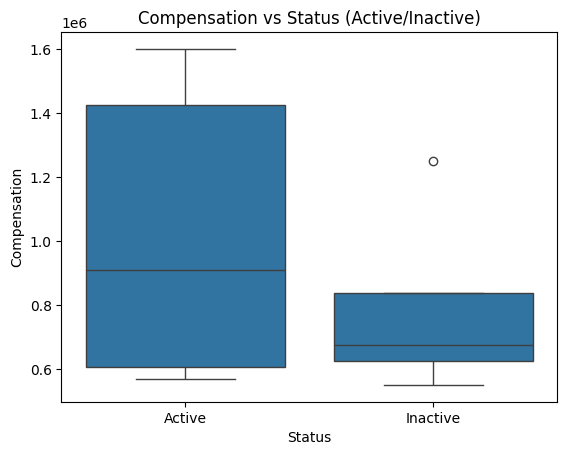

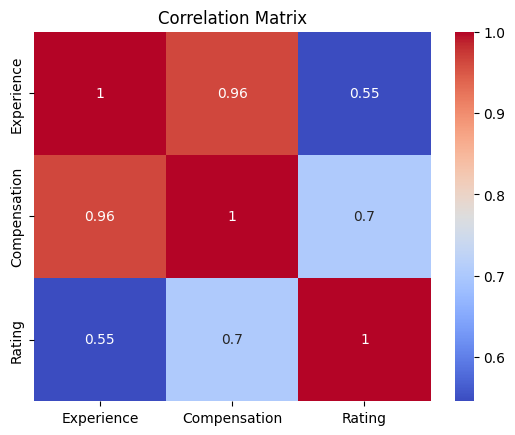

In [ ]:
# Check for patterns
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df, x='Status', y='Compensation')
plt.title("Compensation vs Status (Active/Inactive)")
plt.show()

# Correlation heatmap
corr = df[['Experience', 'Compensation', 'Rating']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


In [ ]:
# Filter senior roles
senior_roles = df[df['Role'].isin(['Senior Associate', 'Manager'])]

# Bonus 10%
bonus_impact = senior_roles['Compensation'].sum() * 0.10

# Stock grant of ₹200,000 per senior employee
stock_impact = len(senior_roles) * 200000

print(f"Total Bonus Payout (10%): ₹{bonus_impact:,.0f}")
print(f"Total Stock Grant Payout: ₹{stock_impact:,.0f}")


Total Bonus Payout (10%): ₹555,000
Total Stock Grant Payout: ₹800,000


In [ ]:
# Filter by role and status
def filter_active_by_role(role):
    filtered = df[(df['Role'] == role) & (df['Status'] == 'Active')]
    return filtered[['Name', 'Role', 'Location', 'Compensation']]

filter_active_by_role("Consultant")


,Name,Role,Location,Compensation
0,Alice,Consultant,Bangalore,600000
5,Frank,Consultant,Mumbai,570000
9,Judy,Consultant,Delhi,620000


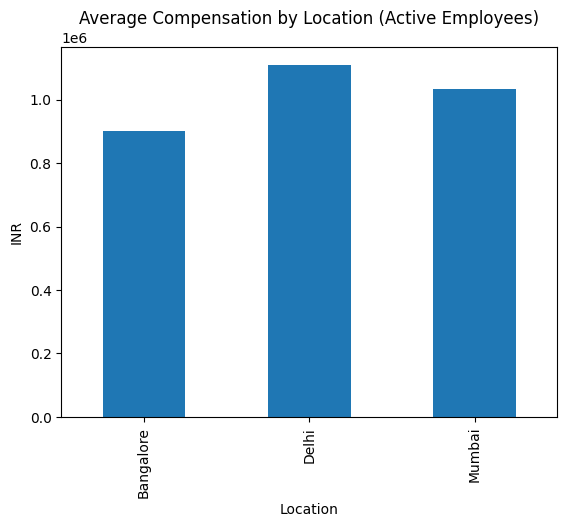

In [ ]:
# Avg compensation by location (Bar Chart)
avg_comp = df[df['Status'] == 'Active'].groupby('Location')['Compensation'].mean()

avg_comp.plot(kind='bar', title="Average Compensation by Location (Active Employees)", ylabel='INR')
plt.show()


In [ ]:
experience_group = df.groupby('ExperienceRange')['EmployeeID'].count()
print("Employees by Experience Range:\n", experience_group)


Employees by Experience Range:
 ExperienceRange
0–2     4
2–5     3
5–10    3
Name: EmployeeID, dtype: int64


<ipython-input-15-dc4c84a6357a>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  experience_group = df.groupby('ExperienceRange')['EmployeeID'].count()


In [ ]:
filtered_data = df[['Name', 'Role', 'Location', 'Experience', 'Compensation', 'Status']]
filtered_data.to_csv('Filtered_Employee_Data.csv', index=False)
print("CSV Exported Successfully")


CSV Exported Successfully


In [ ]:
%%markdown
# Employee Compensation Forecasting App (TechSolve Inc.)

## Tools Used
- Python (Google Colab)
- pandas, seaborn, matplotlib

## Key Features
- Analyze headcount decline
- Compare compensation across roles/locations
- Simulate increments
- Export reports

## How to Run
1. Open in Google Colab
2. Upload data or use dummy
3. Execute each cell as per section

## Screenshots
*Add visual outputs from charts here*


# Employee Compensation Forecasting App (TechSolve Inc.)

## Tools Used
- Python (Google Colab)
- pandas, seaborn, matplotlib

## Key Features
- Analyze headcount decline
- Compare compensation across roles/locations
- Simulate increments
- Export reports

## How to Run
1. Open in Google Colab
2. Upload data or use dummy
3. Execute each cell as per section

## Screenshots
*Add visual outputs from charts here*


In [ ]:
# Project Structure: EmployeeCompensationForecasting

# Root Directory
# - data/
#     - employees.csv                 # Raw employee data
#     - location_compensation.csv     # Location-wise compensation reference
#
# - notebooks/
#     - 01_Data_Cleaning.ipynb
#     - 02_Filter_Employees.ipynb
#     - 03_Compensation_Analysis.ipynb
#     - 04_Increment_Simulation.ipynb
#
# - scripts/
#     - create_tables.py              # Create SQLite tables
#     - filter_employees.py
#     - calculate_average_comp.py
#     - simulate_increment.py
#
# - models/
#     - employee.py
#     - compensation.py
#
# - utils/
#     - db_utils.py                   # DB helpers
#     - viz_utils.py                  # Visualization tools
#
# - README.md
# - requirements.txt                 # List of Python packages
# - .gitignore
# - LICENSE
